# Training stage 1

#### *Note before starting: 
`ImageCleaner` does not work in JupyterLab, but it *does* work in Jupyter Notebook

In [1]:
from fastai.vision import *
from fastai.widgets import *

In [2]:
np.random.seed(42)

In [3]:
path = Path('data')

Create DataBunch `.from_csv` to include the cleaned up data set. <br>
Use transforms to augment the data.

In [7]:
tfms = get_transforms(max_rotate=25., max_zoom=1.25, max_lighting=0.4, max_warp=0.3, p_affine=0.85)

In [8]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


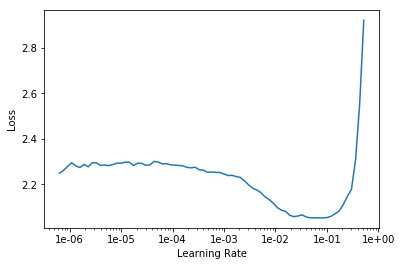

In [10]:
learn.lr_find()
learn.recorder.plot()

Train final layer exclusively

In [11]:
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,2.173887,1.696292,0.710084,00:06
1,1.921865,1.614921,0.609244,00:06
2,1.758477,1.659992,0.584034,00:06
3,1.650244,1.542379,0.542017,00:06
4,1.565941,1.418263,0.508403,00:06
5,1.469453,1.481027,0.512605,00:06
6,1.379504,1.255198,0.453782,00:06
7,1.280165,1.239672,0.428571,00:06
8,1.203550,1.236613,0.415966,00:06
9,1.127863,1.236354,0.415966,00:06


In [12]:
learn.save('res34-stage-1')

# Training stage 2

Train all layers

In [13]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


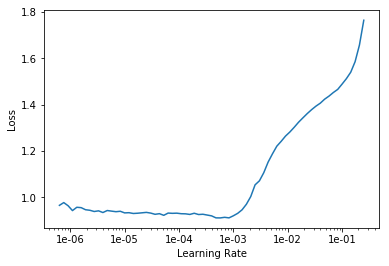

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(10, max_lr=slice(3e-7,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.959680,1.234028,0.428571,00:07
1,0.957279,1.226520,0.424370,00:07
2,0.932536,1.222268,0.424370,00:07
3,0.929496,1.209061,0.415966,00:07
4,0.918862,1.204916,0.420168,00:07
5,0.902148,1.198262,0.420168,00:07
6,0.880278,1.193107,0.415966,00:07
7,0.874375,1.190548,0.407563,00:07
8,0.882536,1.187997,0.407563,00:07
9,0.881797,1.190212,0.407563,00:07


In [16]:
learn.save('res34-stage-2')

# Interpretation

In [20]:
# learn.load('res34-stage-2');

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

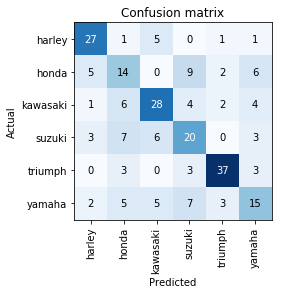

In [18]:
interp.plot_confusion_matrix()

# Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

####  `ImageCleaner` does not work in JupyterLab, but it does work in Jupyter Notebook

Note that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

#### First the Validation Set:

In [19]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [20]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

#### Now the Training Set:

In [21]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Train)

In [23]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

---
---
# New Architecture - Training stage 1

#### Recreate the ImageDataBunch from the `cleaned.csv` to include the changes

Since the `cleaned.csv` file has changed, we will not end up with the exact same train/valid split. Therefore, our current model will have already been trained on images that will be in the new validation set. 

Let's start with a fresh learner with resnet50 architecture and see if the results improve.

In [26]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [27]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


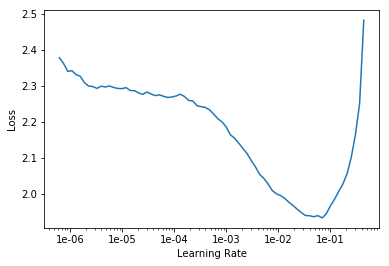

In [28]:
learn.lr_find()
learn.recorder.plot()

Train final layer exclusively

In [29]:
learn.fit_one_cycle(10, max_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.207046,1.804291,0.739362,00:10
1,1.924007,1.614926,0.617021,00:09
2,1.748790,1.833046,0.558511,00:09
3,1.596033,1.958119,0.595745,00:09
4,1.449962,1.687831,0.558511,00:09
5,1.331450,1.548527,0.515957,00:09
6,1.215578,1.542702,0.531915,00:09
7,1.106605,1.459387,0.500000,00:09
8,1.024652,1.421579,0.478723,00:09
9,0.957714,1.418692,0.489362,00:09


In [30]:
learn.save('res50-stage-1')

Train all layers

In [31]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


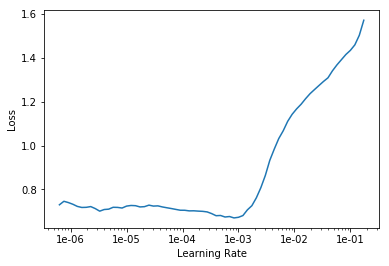

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.712373,1.411910,0.484043,00:11
1,0.728174,1.419813,0.478723,00:11
2,0.731803,1.414792,0.484043,00:11
3,0.716215,1.402091,0.478723,00:11
4,0.703900,1.397718,0.484043,00:11
5,0.694354,1.385922,0.489362,00:11
6,0.676754,1.381730,0.484043,00:11
7,0.665604,1.375408,0.489362,00:11
8,0.654489,1.384786,0.478723,00:11
9,0.650209,1.386405,0.484043,00:11


In [34]:
learn.save('res50-stage-2')

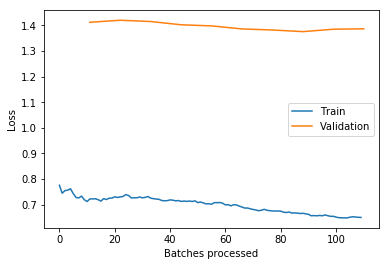

In [37]:
learn.recorder.plot_losses()

# Interpretation - ResNet50

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

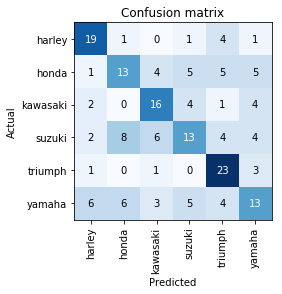

In [36]:
interp.plot_confusion_matrix()

---
---

# Putting the model in production

At this point, we're ready to put our model in production and this is where I hear a lot of people ask me about which mega Google Facebook highly distributed serving system they should use and how do they use a thousand GPUs at the same time. For the vast majority of things you all do, you will want to actually run in production on a CPU, not a GPU. Why is that? Because GPU is good at doing lots of things at the same time, but unless you have a very busy website, it's pretty unlikely that you're going to have 64 images to classify at the same time to put into a batch into a GPU. And if you did, you've got to deal with all that queuing and running it all together, all of your users have to wait until that batch has got filled up and run﹣it's whole a lot of hassle. Then if you want to scale that, there's another whole lot of hassle. 

It's much easier if you just wrap one thing, throw it at a CPU to get it done, and comes back again. Yes, it's going to take maybe 10 or 20 times longer so maybe it'll take 0.2 seconds rather than 0.01 seconds. That's about the kind of times we are talking about. But it's so easy to scale. You can chuck it on any standard serving infrastructure. It's going to be cheap, and you can horizontally scale it really easily.  So most people I know who are running apps that aren't at Google scale, based on deep learning are using CPUs. 

And the term we use is "inference". When you are not training a model but you've got a trained model and you're getting it to predict things, we call that inference. That's why we say here:

> You probably want to use CPU for inference

First thing first, let's export the content of our `Learner` object for production:

This will create a file named 'export.pkl' in the `path` directory that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

In [51]:
learn.export()

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [54]:
path

PosixPath('data/bears')

In [55]:
path.ls()

[PosixPath('data/bears/cleaned.csv'),
 PosixPath('data/bears/urls_teddys.txt'),
 PosixPath('data/bears/black'),
 PosixPath('data/bears/teddys'),
 PosixPath('data/bears/urls_grizzly.txt'),
 PosixPath('data/bears/grizzly'),
 PosixPath('data/bears/models'),
 PosixPath('data/bears/urls_black.txt')]

In [17]:
learn = load_learner(path)

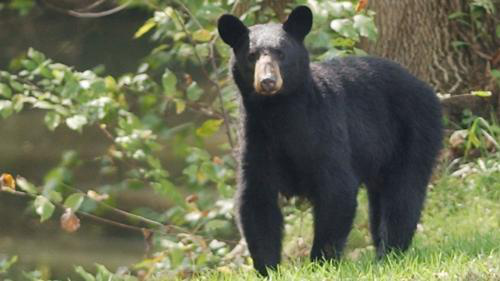

In [15]:
img = open_image(path/'black'/'00000021.jpg')
img

In [21]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category black

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate       
1      12.220007   1144188288.000000  0.765957    (00:13)



### Learning rate (LR) too low

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.349151    1.062807    0.609929    (00:13)
2      1.373262    1.045115    0.546099    (00:13)
3      1.346169    1.006288    0.468085    (00:13)
4      1.334486    0.978713    0.453901    (00:13)
5      1.320978    0.978108    0.446809    (00:13)



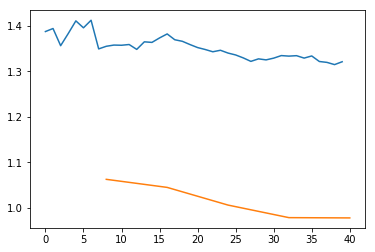

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2